In [1]:
import nltk

In [2]:
from textblob import TextBlob

In [3]:
import matplotlib.pyplot as plt

In [4]:
import requests

In [5]:
import re

In [6]:
#scrape text from a website
url = 'https://www.gutenberg.org/cache/epub/8164/pg8164.txt'

In [7]:
response = requests.get(url)

In [8]:
full_text = response.text

In [9]:
#text processing steps
#extract text for the first story 
start_marker = 'Jeeves—my man, you know—is really a most extraordinary chap'
end_marker = '“I endeavour to give satisfaction, sir,” said Jeeves.'

start_index = full_text.find(start_marker)
end_index = full_text.find(end_marker, start_index) + len(start_marker)

text = full_text[start_index:end_index].strip() 
#text = text.group(0)        #convert object type back to string

In [10]:
#remove special characters and punctuation marks - by keeping every character that is either alphanumeric or a space
#also convert uppercase letters to lowercase
text = re.sub(r'[^A-Za-z0-9\s]', '', text).lower()

In [11]:
#remove stopwords (words that don't carry much meaning - and, or, over, in, etc.)
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
text = ' '.join([word for word in text.split() if word not in stop_words])

In [12]:
#lemmatisation
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [13]:
#import libraries for sentiment analysis
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import torch

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Load distilBERT (lighter, faster pre-trained sentiment analysis pipeline)
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [15]:
#create tokens using the tokenizer from the transformers library (ignore warning; token length adjustment is in the next step)
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Tokenize the entire lemmatised text
tokens = tokenizer.tokenize(text)

Token indices sequence length is longer than the specified maximum sequence length for this model (7883 > 512). Running this sequence through the model will result in indexing errors


In [16]:
#divide tokenized text into chunks of 510 or less tokens
max_chunk_size = 20
token_chunks = [tokens[i:i + max_chunk_size] for i in range(0, len(tokens), max_chunk_size)]

In [17]:
#edit each token chunk to fit BERT formatting requirements (needs to start and end with 'CLS' and 'SEP', respectively)
input_data = [
    {
        "input_ids": tokenizer.convert_tokens_to_ids(["[CLS]"] + chunk + ["[SEP]"]) +
                     [tokenizer.pad_token_id] * (512 - len(chunk) - 2),
        "attention_mask": [1] * (len(chunk) + 2) + [0] * (512 - len(chunk) - 2)
    }
    for chunk in token_chunks
]

In [18]:
from transformers import AutoModelForSequenceClassification
import torch

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Convert input IDs and attention masks to tensors
input_ids = torch.tensor([item["input_ids"] for item in input_data])
attention_masks = torch.tensor([item["attention_mask"] for item in input_data])

# Run the model on the tokenized chunks with attention masks
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)  # Provide both input IDs and attention masks
    predictions = torch.softmax(outputs.logits, dim=-1)  # Get probabilities for each class (e.g., positive/negative)

# Print predictions
#print(predictions)

In [19]:
positive_scores = predictions[:, 1].numpy()  # Positive score for each chunk
overall_sentiment = "POSITIVE" if positive_scores.mean() > 0.5 else "NEGATIVE"
print(f"Overall Sentiment: {overall_sentiment}")

Overall Sentiment: NEGATIVE


In [20]:
#plotting time
#extract positive sentiment scores from the model output tensor, convert to array
positive_scores = predictions[:, 1].numpy()

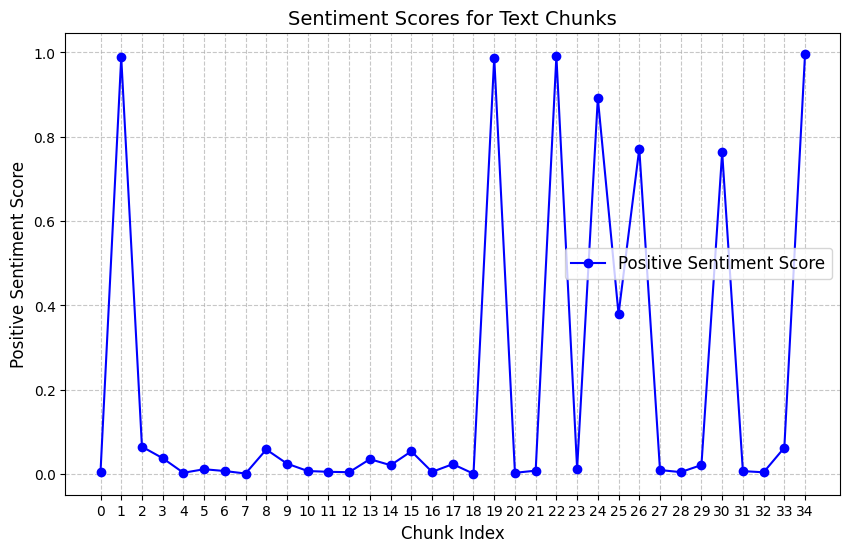

In [25]:
# Create x-axis labels (chunk indices)
chunk_indices = np.arange(len(positive_scores[360:395]))  # 0, 1, 2, ...

# Plot the sentiment scores for the last 35 chunks - to visualise the story ending in particular
plt.figure(figsize=(10, 6))
plt.plot(chunk_indices, positive_scores[360:395], marker='o', linestyle='-', color='b', label='Positive Sentiment Score')
plt.title('Sentiment Scores for Text Chunks', fontsize=14)
plt.xlabel('Chunk Index', fontsize=12)
plt.ylabel('Positive Sentiment Score', fontsize=12)
plt.xticks(chunk_indices)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

In [22]:
#Model gets overall sentiment wrong: the short story is broadly a comedy, but the aggregate result says that the overall sentiment is 'negative'.
#Things to consider: adjusting chunk size, or aggregation method for overall sentiment.
#However, the model is right in a limited way: it does figure out that the story has a happy ending.